## Clean Fanstream Functions

In [1]:
import json
import re
from typing import Dict, Any, Iterable, List, Optional, Tuple
import pandas as pd

# --- Header parsing helpers ---------------------------------------------------

GUID_RE = re.compile(r"[0-9a-fA-F]{8}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{4}-[0-9a-fA-F]{12}")
ISO_TS_RE = re.compile(r"\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}(?:\.\d+)?")
INT_RE = re.compile(r"^\d+$")
EVENTTYPE_RE = re.compile(r"[A-Za-z][A-Za-z0-9_]*")

def _parse_prefix_header(prefix: str) -> Dict[str, Optional[str]]:
    """
    Extract correlation_id, message_id, event_time, seq, event_type
    from the non-JSON prefix of a log line. Robust to extra tokens like
    '2566 :' at the beginning.
    """
    hdr: Dict[str, Optional[str]] = {}

    # GUIDs
    guids = GUID_RE.findall(prefix)
    if guids:
        hdr["correlation_id"] = guids[0]
    if len(guids) > 1:
        hdr["message_id"] = guids[1]

    # Timestamp
    ts = ISO_TS_RE.search(prefix)
    if ts:
        hdr["event_time"] = ts.group(0)

    # Split on '::' to evaluate tail tokens
    parts = [p.strip() for p in prefix.split("::") if p.strip()]

    # Sequence number: pick the last pure integer token
    for p in reversed(parts):
        if INT_RE.fullmatch(p):
            hdr["seq"] = p
            break

    # Event type: pick the last token that looks like an identifier
    for p in reversed(parts):
        if EVENTTYPE_RE.fullmatch(p):
            # avoid misclassifying raw integers or GUID fragments
            if not INT_RE.fullmatch(p) and not GUID_RE.fullmatch(p):
                hdr["event_type"] = p
                break

    return hdr

def _coerce_float(x):
    try:
        return float(x)
    except (TypeError, ValueError):
        return None

# --- Log iteration & normalization -------------------------------------------

def _iter_events_with_json(path: str) -> Iterable[Tuple[Dict[str, Any], Dict[str, Any]]]:
    """
    Iterate the file. For each line:
      - Parse header info from any text BEFORE the first '{' (same line),
      - Also remember the most recent header-only line (no JSON),
      - Yield (merged_header, json_obj) when a JSON payload is present.
    """
    carry_header: Dict[str, Any] = {}

    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.rstrip("\n")
            first_brace = line.find("{")

            # Always parse header from the prefix (even if JSON is present)
            prefix = line[:first_brace] if first_brace != -1 else line
            parsed_now = _parse_prefix_header(prefix)

            if first_brace == -1:
                # header-only line
                if parsed_now:
                    carry_header = {k: v for k, v in parsed_now.items() if v is not None}
                continue

            # Try to parse JSON payload
            payload = line[first_brace:]
            try:
                obj = json.loads(payload)
            except json.JSONDecodeError:
                m = re.search(r"\{.*\}$", line)
                if not m:
                    # No parseable JSON on this line
                    continue
                try:
                    obj = json.loads(m.group(0))
                except json.JSONDecodeError:
                    continue

            # Merge headers: values on the same line override carried ones
            merged_header = dict(carry_header)
            merged_header.update({k: v for k, v in parsed_now.items() if v is not None})
            yield (merged_header, obj)

def _extract_rows_from_obj(obj: Dict[str, Any]) -> Iterable[Dict[str, Any]]:
    """
    Normalize object shapes to rows with selection_id, price, probability, etc.
    Supports:
      - {"Selections":[{SelectionId, Price, Probability, MarketId, Name, ...}], "FixtureId": ...}
      - {"Markets":[{"Selections":[{...}], "MarketId": ...}, ...], "FixtureId": ...}
    """
    if isinstance(obj.get("Selections"), list):
        fid = obj.get("FixtureId")
        for s in obj["Selections"]:
            yield {
                "fixture_id": fid,
                "market_id": s.get("MarketId"),
                "selection_id": s.get("SelectionId"),
                "name": s.get("Name"),
                "price": _coerce_float(s.get("Price")),
                "probability": _coerce_float(s.get("Probability")),
            }
    elif isinstance(obj.get("Markets"), list):
        fid = obj.get("FixtureId")
        for m in obj["Markets"]:
            mid = m.get("MarketId")
            for s in (m.get("Selections") or []):
                yield {
                    "fixture_id": fid,
                    "market_id": s.get("MarketId") or mid,
                    "selection_id": s.get("SelectionId"),
                    "name": s.get("Name"),
                    "price": _coerce_float(s.get("Price")),
                    "probability": _coerce_float(s.get("Probability")),
                }

def parse_all_selections_with_meta(path: str) -> pd.DataFrame:
    """
    Expand the log into one row per (event × selection).
    Adds header metadata: correlation_id, message_id, event_time, seq, event_type.
    """
    rows: List[Dict[str, Any]] = []
    event_idx = 0

    for header, obj in _iter_events_with_json(path):
        extracted = False
        for row in _extract_rows_from_obj(obj):
            sid = row.get("selection_id")
            if sid is None:
                continue
            rec = {
                "event_idx": event_idx,
                "event_time": header.get("event_time"),
                "event_type": header.get("event_type"),
                "seq": header.get("seq"),
                "correlation_id": header.get("correlation_id"),
                "message_id": header.get("message_id"),
                **row,
            }
            rows.append(rec)
            extracted = True
        if extracted:
            event_idx += 1

    cols_front = [
        "event_idx", "event_time", "event_type", "seq",
        "correlation_id", "message_id",
        "fixture_id", "market_id", "selection_id", "price", "probability", "name",
    ]
    if not rows:
        return pd.DataFrame(columns=cols_front)

    df = pd.DataFrame(rows)
    # Ensure consistent column order and sort
    for c in cols_front:
        if c not in df.columns:
            df[c] = None
    df = df[cols_front].sort_values(["event_idx", "selection_id"]).reset_index(drop=True)
    return df


## Clean Markets Added Functions

In [2]:
import json
import pandas as pd

path = r"C:\Temp\all-archive-production-4000030783-MarketsAdded.Golf.json"

def extract_selections(path, market_id=1000001):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line.split(" :: ")[-1])
            except json.JSONDecodeError:
                continue
            markets = obj.get("Markets", {})
            for m in markets.values():
                if m.get("MarketDefinitionId") == market_id:
                    for sel in m.get("Selections", []):
                        rows.append({
                            "MarketDefinitionId": m.get("MarketDefinitionId"),
                            "SelectionDefinitionId": sel.get("SelectionDefinitionId"),
                            "Name": sel.get("Name")
                        })
    return pd.DataFrame(rows)


## Tournament Winner

### Cleaning Data

In [8]:
PATH = r"../DL Mustard Analysis/Data/4000001127-uat-fanstream-hub-output-tournament-winner.json"
df_dl_tournament_winner = parse_all_selections_with_meta(PATH)
df_dl_tournament_winner['feed'] = 'DL'
df_dl_tournament_winner['market_name'] = 'Tournament Winner'

dl_player_names_tournament_winner = df_dl_tournament_winner[df_dl_tournament_winner['market_id'] == '1000001'][['name', 'selection_id']].drop_duplicates()


PATH = r"../DL Mustard Analysis/Data/4000030783-production-fanstream-hub-output-tournament-winner.json"
df_mustard_tournament_winner = parse_all_selections_with_meta(PATH)
df_mustard_tournament_winner['feed'] = 'Mustard'
df_mustard_tournament_winner['market_name'] = 'Tournament Winner'


PATH = r"C:\Temp\all-archive-production-4000030783-MarketsAdded.Golf.json"
mustard_player_names_tournament_winner = extract_selections(PATH, 1000001)
mustard_player_names_tournament_winner = mustard_player_names_tournament_winner[['Name', 'SelectionDefinitionId']].rename(columns={'Name' : 'name', 
                                                                                                                                   'SelectionDefinitionId' : 'selection_id'}).drop_duplicates()

import pandas as pd
import re

def clean_name(name: str) -> str:
    """Lowercase and remove non-alphanumeric characters (except spaces)."""
    if pd.isna(name):
        return ""
    return re.sub(r'[^a-z0-9 ]', '', name.lower())

# Make copies so we don’t overwrite originals
dl = dl_player_names_tournament_winner.copy()
mustard = mustard_player_names_tournament_winner.copy()

# Apply cleaning
dl["clean_name"] = dl["name"].apply(clean_name)
mustard["clean_name"] = mustard["name"].apply(clean_name)

# Merge on clean_name
player_names_mapped = pd.merge(
    dl,
    mustard,
    on="clean_name",
    suffixes=("_dl", "_mustard")
)


# Build lookup (same as before)
import pandas as pd

# 1. Build lookup table from the name-joined DF
lookup = (
    player_names_mapped
    .drop_duplicates("selection_id_mustard")
    .set_index("selection_id_mustard")[["selection_id_dl", "name_dl"]]
)

# 2. Make sure selection_id in mustard df is numeric
df_mustard_tournament_winner["selection_id"] = pd.to_numeric(
    df_mustard_tournament_winner["selection_id"], errors="coerce"
).astype("Int64")

# 3. Map to DL ids/names
df_mustard_tournament_winner["dl_selection_id"] = df_mustard_tournament_winner["selection_id"].map(
    lookup["selection_id_dl"]
)
df_mustard_tournament_winner["dl_name"] = df_mustard_tournament_winner["selection_id"].map(
    lookup["name_dl"]
)

# 4. Replace old columns with DL versikj u45cxy7gons
df_mustard_tournament_winner = df_mustard_tournament_winner.drop(columns=["name"], errors="ignore")

df_mustard_tournament_winner["selection_id"] = df_mustard_tournament_winner["dl_selection_id"]
df_mustard_tournament_winner = df_mustard_tournament_winner.drop(columns=["dl_selection_id"])

df_mustard_tournament_winner["name"] = df_mustard_tournament_winner["dl_name"]
df_mustard_tournament_winner = df_mustard_tournament_winner.drop(columns=["dl_name"])

tournament_winner_df = pd.concat([df_dl_tournament_winner, df_mustard_tournament_winner], axis=0)

tournament_winner_df["event_time"] = pd.to_datetime(tournament_winner_df["event_time"], errors="coerce")

tournament_winner_df

,event_idx,event_time,event_type,seq,correlation_id,message_id,fixture_id,market_id,selection_id,price,probability,name,feed,market_name
0,0,2025-08-14 01:22:07,SelectionsUpdated,61142643,0eb20755-06f2-48ed-832e-847e9d08ad05,8408726b-a965-4ed8-a4ae-2654376d2991,4000001127,1000001,10000010003,91.0,0.010989,None,DL,Tournament Winner
1,0,2025-08-14 01:22:07,SelectionsUpdated,61142643,0eb20755-06f2-48ed-832e-847e9d08ad05,8408726b-a965-4ed8-a4ae-2654376d2991,4000001127,1000001,10000010015,81.0,0.012346,None,DL,Tournament Winner
2,0,2025-08-14 01:22:07,SelectionsUpdated,61142643,0eb20755-06f2-48ed-832e-847e9d08ad05,8408726b-a965-4ed8-a4ae-2654376d2991,4000001127,1000001,10000010019,51.0,0.019608,None,DL,Tournament Winner
3,0,2025-08-14 01:22:07,SelectionsUpdated,61142643,0eb20755-06f2-48ed-832e-847e9d08ad05,8408726b-a965-4ed8-a4ae-2654376d2991,4000001127,1000001,10000010021,61.0,0.016393,None,DL,Tournament Winner
4,0,2025-08-14 01:22:07,SelectionsUpdated,61142643,0eb20755-06f2-48ed-832e-847e9d08ad05,8408726b-a965-4ed8-a4ae-2654376d2991,4000001127,1000001,10000010029,3.8,0.266667,None,DL,Tournament Winner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12339,5095,2025-08-16 23:06:41,SelectionsResulted,3834188,85768d02-a6e7-4d9f-8b58-6e40a913247e,b33b98c1-f296-4ad5-bd22-01f6468e04be,4000030783,1000001,NaN,NaN,NaN,NaN,Mustard,Tournament Winner
12340,5095,2025-08-16 23:06:41,SelectionsResulted,3834188,85768d02-a6e7-4d9f-8b58-6e40a913247e,b33b98c1-f296-4ad5-bd22-01f6468e04be,4000030783,1000001,NaN,NaN,NaN,NaN,Mustard,Tournament Winner
12341,5095,2025-08-16 23:06:41,SelectionsResulted,3834188,85768d02-a6e7-4d9f-8b58-6e40a913247e,b33b98c1-f296-4ad5-bd22-01f6468e04be,4000030783,1000001,NaN,NaN,NaN,NaN,Mustard,Tournament Winner
12342,5095,2025-08-16 23:06:41,SelectionsResulted,3834188,85768d02-a6e7-4d9f-8b58-6e40a913247e,b33b98c1-f296-4ad5-bd22-01f6468e04be,4000030783,1000001,NaN,NaN,NaN,NaN,Mustard,Tournament Winner


### Plots

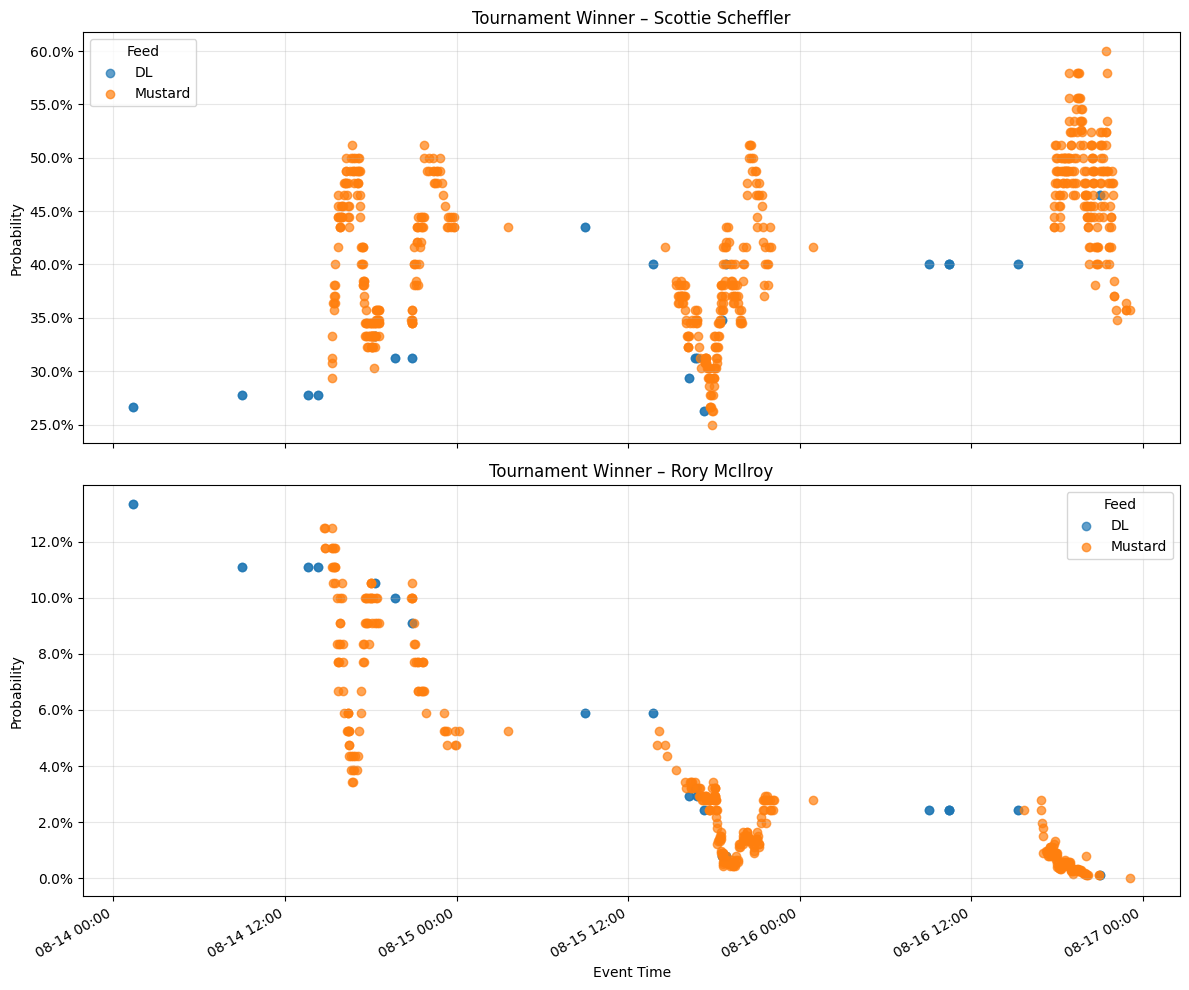

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# ---------------- Scottie Scheffler ----------------
df_scottie = tournament_winner_df[
    (tournament_winner_df['name'] == 'Scottie Scheffler') 
].copy()

df_scottie["event_time"] = pd.to_datetime(df_scottie["event_time"], errors="coerce")
df_scottie["probability"] = pd.to_numeric(df_scottie["probability"], errors="coerce")
df_scottie = df_scottie.dropna(subset=["event_time", "probability", "feed"]).sort_values("event_time")

for feed, g in df_scottie.groupby("feed"):
    axes[0].scatter(g["event_time"], g["probability"], label=feed, alpha=0.7)

axes[0].set_title("Tournament Winner – Scottie Scheffler")
axes[0].set_ylabel("Probability")
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))  # format as %
axes[0].legend(title="Feed")
axes[0].grid(True, alpha=0.3)

# ---------------- Rory McIlroy ----------------
df_rory = tournament_winner_df[
    (tournament_winner_df['name'] == 'Rory Mcilroy') &
    (tournament_winner_df['market_id'] == '1000001')
].copy()

df_rory["event_time"] = pd.to_datetime(df_rory["event_time"], errors="coerce")
df_rory["probability"] = pd.to_numeric(df_rory["probability"], errors="coerce")
df_rory = df_rory.dropna(subset=["event_time", "probability", "feed"]).sort_values("event_time")

for feed, g in df_rory.groupby("feed"):
    axes[1].scatter(g["event_time"], g["probability"], label=feed, alpha=0.7)

axes[1].set_title("Tournament Winner – Rory McIlroy")
axes[1].set_xlabel("Event Time")
axes[1].set_ylabel("Probability")
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))  # format as %
axes[1].legend(title="Feed")
axes[1].grid(True, alpha=0.3)

# ---------------- Format X-axis ----------------
date_format = DateFormatter("%m-%d %H:%M")   # <-- show month-day and hour:minute
axes[1].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### N Updates

In [ ]:
tournament_winner_df.groupby(['name', 'feed']).size().reset_index(name='count')

tournament_winner_n_updates_df = (
    tournament_winner_df
    .groupby(['name', 'feed'])
    .size()
    .reset_index(name='count')
    .pivot(index='name', columns='feed', values='count')
    .fillna(0)  
)

tournament_winner_n_updates_df = tournament_winner_n_updates_df.sort_values('Mustard', ascending=False).rename(columns={'DL' : 'DL_updates', 'Mustard' : 'Mustard_updates'})

# tournament_winner_n_updates_df.to_csv('tournament_winner_n_updates_df.csv')


feed,DL_updates,Mustard_updates
name,,
Scottie Scheffler,40,569
Robert Macintyre,40,525
Michael Kim,40,485
Viktor Hovland,40,479
Sam Burns,40,465
Harry Hall,40,463
Tommy Fleetwood,40,461
Maverick Mcnealy,40,459
Rickie Fowler,40,457


### Margin

In [112]:
# Ensure event_time is datetime
tournament_winner_df["event_time"] = pd.to_datetime(tournament_winner_df["event_time"], errors="coerce")

# Define start and end times
start = pd.to_datetime("2025-08-14T14:10:13.000")
end   = pd.to_datetime("2025-08-14T20:53:21.000")

# Filter rows between the two timestamps
filtered = tournament_winner_df[
    (tournament_winner_df["event_time"] >= start) &
    (tournament_winner_df["event_time"] <= end)
]

# Group by name + feed, average probability
avg_probs = (
    filtered
    .groupby(['name', 'feed'])['probability']
    .mean()
    .reset_index()
)

# Pivot so feed becomes columns, name is index
tournament_winner_margin_df = (
    avg_probs
    .pivot(index='name', columns='feed', values='probability')
    .fillna(0)   # optional: replace NaN with 0
).sort_values('Mustard', ascending=False).rename(columns={'DL' : 'DL %', 'Mustard' : 'Mustard %'})

# tournament_winner_margin_df.sort_values('Mustard', ascending=False).to_csv('tournament_winner_margin_df.csv')
tournament_winner_agg_df = tournament_winner_margin_df.merge(tournament_winner_n_updates_df, how='left', on='name')

tournament_winner_agg_df.sort_values('Mustard_updates', ascending=False).to_csv('tournament_winner_agg_df.csv')

tournament_winner_agg_df


feed,DL %,Mustard %,DL_updates,Mustard_updates
name,,,,
Scottie Scheffler,0.307870,0.393408,40,569
Rory Mcilroy,0.105458,0.083533,40,394
Tommy Fleetwood,0.059374,0.063884,40,461
Ben Griffin,0.044347,0.050239,40,270
Ludvig Åberg,0.046921,0.043256,40,432
Cameron Young,0.043478,0.038408,40,330
Sam Burns,0.044347,0.036575,40,465
Patrick Cantlay,0.038245,0.034675,40,235
J.J. Spaun,0.028545,0.032085,40,327


## Round Leaders

### Cleaning Data

In [10]:
PATH = r"../DL Mustard Analysis/Data/4000001127-uat-fanstream-hub-output-1st-round-leader.json"
df_dl_1st_round_leader = parse_all_selections_with_meta(PATH)
df_dl_1st_round_leader['feed'] = 'DL'
df_dl_1st_round_leader['market_name'] = '1st Round Leader'

PATH = r"../DL Mustard Analysis/Data/4000001127-uat-fanstream-hub-output-2nd-round-leader.json"
df_dl_2nd_round_leader = parse_all_selections_with_meta(PATH)
df_dl_2nd_round_leader['feed'] = 'DL'
df_dl_2nd_round_leader['market_name'] = '2nd Round Leader'


PATH = r"../DL Mustard Analysis/Data/4000001127-uat-fanstream-hub-output-3rd-round-leader.json"
df_dl_3rd_round_leader = parse_all_selections_with_meta(PATH)
df_dl_3rd_round_leader['feed'] = 'DL'
df_dl_3rd_round_leader['market_name'] = '3rd Round Leader'


PATH = r"../DL Mustard Analysis/Data/4000030783-production-fanstream-hub-output-1st-round-leader.json"
df_mustard_1st_round_leader = parse_all_selections_with_meta(PATH)
df_mustard_1st_round_leader['feed'] = 'Mustard'
df_mustard_1st_round_leader['market_name'] = '1st Round Leader'

PATH = r"../DL Mustard Analysis/Data/4000030783-production-fanstream-hub-output-2nd-round-leader.json"
df_mustard_2nd_round_leader = parse_all_selections_with_meta(PATH)
df_mustard_2nd_round_leader['feed'] = 'Mustard'
df_mustard_2nd_round_leader['market_name'] = '2nd Round Leader'


PATH = r"../DL Mustard Analysis/Data/4000030783-production-fanstream-hub-output-3rd-round-leader.json"
df_mustard_3rd_round_leader = parse_all_selections_with_meta(PATH)
df_mustard_3rd_round_leader['feed'] = 'Mustard'
df_mustard_3rd_round_leader['market_name'] = '3rd Round Leader'

round_leader_df = pd.concat(
    [
        df_dl_1st_round_leader,
        df_dl_2nd_round_leader,
        df_dl_3rd_round_leader,
        df_mustard_1st_round_leader,
        df_mustard_2nd_round_leader,
        df_mustard_3rd_round_leader
    ],
    ignore_index=True
)

round_leader_df

# Ensure event_time is datetime
round_leader_df["event_time"] = pd.to_datetime(round_leader_df["event_time"], errors="coerce")




### Plots

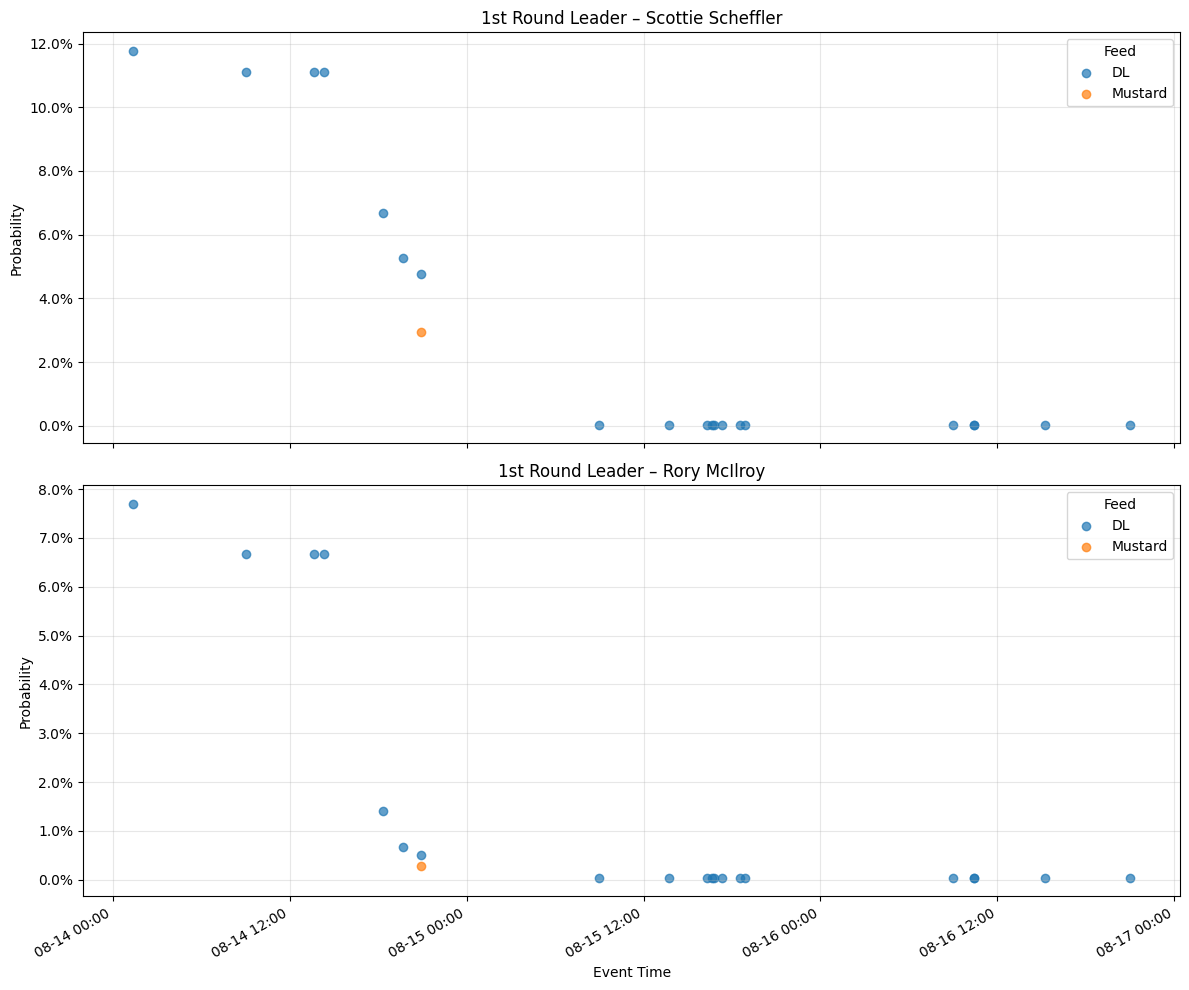

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Scottie Scheffler ---
df_scottie = round_leader_df[
    (round_leader_df['name'] == 'Scottie Scheffler') &
    (round_leader_df['market_name'] == '1st Round Leader') &
    (round_leader_df['market_id'] == '5000001') 
].copy()

df_scottie["event_time"] = pd.to_datetime(df_scottie["event_time"], errors="coerce")
df_scottie["probability"] = pd.to_numeric(df_scottie["probability"], errors="coerce")
df_scottie = df_scottie.dropna(subset=["event_time", "probability", "feed"]).sort_values("event_time")

for feed, g in df_scottie.groupby("feed"):
    axes[0].scatter(g["event_time"], g["probability"], label=feed, alpha=0.7)

axes[0].set_title("1st Round Leader – Scottie Scheffler")
axes[0].set_ylabel("Probability")
axes[0].yaxis.set_major_formatter(PercentFormatter(1.0))  # format as %
axes[0].legend(title="Feed")
axes[0].grid(True, alpha=0.3)

# --- Rory McIlroy ---
df_rory = round_leader_df[
    (round_leader_df['name'] == 'Rory Mcilroy') &
    (round_leader_df['market_name'] == '1st Round Leader') &
    (round_leader_df['market_id'] == '5000001') 
].copy()

df_rory["event_time"] = pd.to_datetime(df_rory["event_time"], errors="coerce")
df_rory["probability"] = pd.to_numeric(df_rory["probability"], errors="coerce")
df_rory = df_rory.dropna(subset=["event_time", "probability", "feed"]).sort_values("event_time")

for feed, g in df_rory.groupby("feed"):
    axes[1].scatter(g["event_time"], g["probability"], label=feed, alpha=0.7)

axes[1].set_title("1st Round Leader – Rory McIlroy")
axes[1].set_xlabel("Event Time")
axes[1].set_ylabel("Probability")
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))  # format as %
axes[1].legend(title="Feed")
axes[1].grid(True, alpha=0.3)

# ---------------- Format X-axis ----------------
date_format = DateFormatter("%m-%d %H:%M")   # show month-day and hour:minute
for ax in axes:
    ax.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


### N Updates

In [164]:
round_1_leader_n_updates_df = (
    round_leader_df[
    (round_leader_df['market_name'] == '1st Round Leader') &
    (round_leader_df['market_id'] == '5000001') 
    ]
    .groupby(['market_name', 'name', 'feed'])
    .size()
    .reset_index(name='count')
    .pivot(index=['market_name', 'name'], columns='feed', values='count')
    .fillna(0)  
).reset_index()

round_1_leader_n_updates_df = round_1_leader_n_updates_df.sort_values('Mustard', ascending=False).rename(columns={'DL' : 'DL_updates', 'Mustard' : 'Mustard_updates'})


round_1_leader_n_updates_df




feed,market_name,name,DL_updates,Mustard_updates
0,1st Round Leader,Akshay Bhatia,20.0,1.0
41,1st Round Leader,Sam Burns,20.0,1.0
30,1st Round Leader,Maverick Mcnealy,20.0,1.0
31,1st Round Leader,Michael Kim,20.0,1.0
32,1st Round Leader,Min Woo Lee,0.0,1.0
33,1st Round Leader,Nick Taylor,20.0,1.0
34,1st Round Leader,Patrick Cantlay,20.0,1.0
35,1st Round Leader,Rickie Fowler,20.0,1.0
36,1st Round Leader,Robert Macintyre,20.0,1.0
37,1st Round Leader,Rory Mcilroy,20.0,1.0


### Margin

In [165]:

# Define start and end times
start = pd.to_datetime("2025-08-14T20:20:13.000")
end   = pd.to_datetime("2025-08-15T00:00:21.000")

# Filter rows between the two timestamps
filtered = round_leader_df[
    (round_leader_df['market_name'] == '1st Round Leader') &
    (round_leader_df['market_id'] == '5000001') &
    (round_leader_df["event_time"] >= start) &
    (round_leader_df["event_time"] <= end)
    ]

# Group by name + feed, average probability
avg_probs = (
    filtered
    .groupby(['name', 'feed'])['probability']
    .mean()
    .reset_index()
)

# Pivot so feed becomes columns, name is index
round_leader_margin_df = (
    avg_probs
    .pivot(index='name', columns='feed', values='probability')
    .fillna(0)   # optional: replace NaN with 0
).sort_values('Mustard', ascending=False).rename(columns={'DL' : 'DL %', 'Mustard' : 'Mustard %'})

round_leader_agg_df = round_leader_margin_df.merge(round_1_leader_n_updates_df, how='left', on='name')

round_leader_agg_df.sort_values('Mustard_updates', ascending=False).to_csv('round_leader_agg_df.csv')

round_leader_agg_df


feed,name,DL %,Mustard %,market_name,DL_updates,Mustard_updates
0,Rickie Fowler,0.230769,0.238095,1st Round Leader,20.0,1.0
1,Viktor Hovland,0.266667,0.142857,1st Round Leader,20.0,1.0
2,Robert Macintyre,0.100000,0.142857,1st Round Leader,20.0,1.0
3,Sam Burns,0.117647,0.142857,1st Round Leader,20.0,1.0
4,Cameron Young,0.058824,0.083333,1st Round Leader,20.0,1.0
5,Ben Griffin,0.105263,0.076923,1st Round Leader,20.0,1.0
6,Jason Day,0.066667,0.076923,1st Round Leader,20.0,1.0
7,Si Woo Kim,0.058824,0.066667,1st Round Leader,20.0,1.0
8,Tommy Fleetwood,0.052632,0.058824,1st Round Leader,20.0,1.0
9,Hideki Matsuyama,0.038462,0.058824,1st Round Leader,20.0,1.0


## Hole Scorer

### Cleaning Data

In [11]:
# ---- DL feed: Hole Scorer (1st hole, Round 1) ----
PATH = r"../DL Mustard Analysis/Data/4000001127-uat-fanstream-hub-output-1st-hole-score-round-1.json"
df_dl_hole1_round1 = parse_all_selections_with_meta(PATH)
df_dl_hole1_round1['feed'] = 'DL'
df_dl_hole1_round1['market_name'] = '1st Hole Score - Round 1'

# ---- Mustard feed: Hole Scorer (1st hole, Round 1) ----
PATH = r"../DL Mustard Analysis/Data/4000030783-production-fanstream-hub-output-1st-hole-score-round-1.json"
df_mustard_hole1_round1 = parse_all_selections_with_meta(PATH)
df_mustard_hole1_round1['feed'] = 'Mustard'
df_mustard_hole1_round1['market_name'] = '1st Hole Score - Round 1'

hole_scorer_df = pd.concat([df_dl_hole1_round1, df_mustard_hole1_round1], ignore_index=True)


### Plots

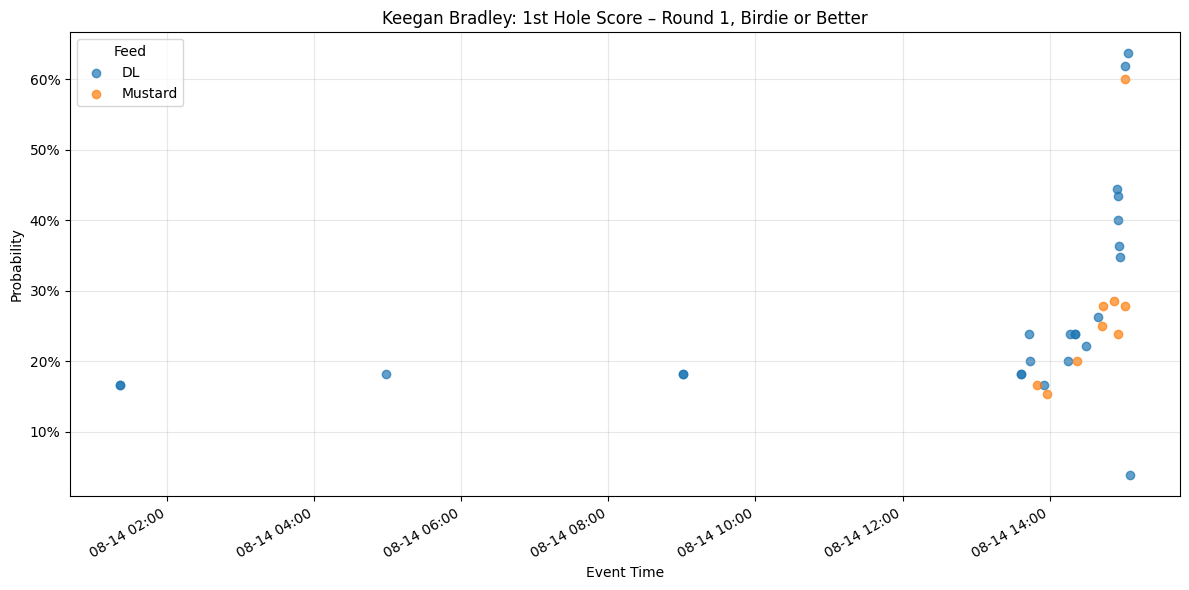

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter

# ---------------- Filter Data ----------------
df_bradley = hole_scorer_df[
    (hole_scorer_df['selection_id'].isin(['130000590001', '130000230001']))
].copy()

df_bradley["event_time"] = pd.to_datetime(df_bradley["event_time"], errors="coerce")
df_bradley["probability"] = pd.to_numeric(df_bradley["probability"], errors="coerce")
df_bradley = df_bradley.sort_values("event_time")

# ---------------- Plot ----------------
fig, ax = plt.subplots(figsize=(12, 6))

for feed, g in df_bradley.groupby("feed"):
    ax.scatter(g["event_time"], g["probability"], label=feed, alpha=0.7)

ax.set_title("Keegan Bradley: 1st Hole Score – Round 1, Birdie or Better")
ax.set_xlabel("Event Time")
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # format as %
ax.legend(title="Feed")
ax.grid(True, alpha=0.3)

# Format x-axis
date_format = DateFormatter("%m-%d %H:%M")   # month-day hour:minute
ax.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [199]:
hole_scorer_df[
    (hole_scorer_df['selection_id'].isin(['130000590001', '130000230001']))
    ]

,event_idx,event_time,event_type,seq,correlation_id,message_id,fixture_id,market_id,selection_id,price,probability,name,feed,market_name
0,0,2025-08-14T01:22:07.000,MarketsCreated,61142646,929eafa1-fe5c-429f-bce1-e8e34b775d20,1925a5f5-70ff-4557-9545-4b13dd4b48fa,4000001127,13000059,130000590001,6.0000,0.166667,Birdie Or Better,DL,1st Hole Score - Round 1
3,1,2025-08-14T01:22:07.000,SelectionsUpdated,61142656,7781f505-bd07-49c6-9864-e879b2e0b5a0,2d4982f1-f710-4ab6-a2f0-5f70628390da,4000001127,13000059,130000590001,6.0000,0.166667,None,DL,1st Hole Score - Round 1
7,3,2025-08-14T04:58:46.000,SelectionsUpdated,61150190,0f9c8391-ea13-4f53-9945-5ce768078578,bf28c80c-3368-472b-9e88-f8425db96762,4000001127,13000059,130000590001,5.5000,0.181818,None,DL,1st Hole Score - Round 1
11,6,2025-08-14T09:00:42.000,MarketsCreated,61161006,4859e248-0241-4f2b-9332-8047d6d65cc1,89a3bed3-0a34-4f58-849d-44df0ec1040f,4000001127,13000059,130000590001,5.5000,0.181818,Birdie Or Better,DL,1st Hole Score - Round 1
14,7,2025-08-14T09:00:42.000,SelectionsUpdated,61161017,5771dd2e-1b16-4a62-8400-743087b16d01,30e41669-9bb6-4774-a798-7f46878a6378,4000001127,13000059,130000590001,5.5000,0.181818,None,DL,1st Hole Score - Round 1
18,9,2025-08-14T13:36:48.000,MarketsCreated,61179882,5723d878-1160-4d53-957f-382649ebdd86,70842f15-bd62-44a9-bf28-670e6cf49bb4,4000001127,13000059,130000590001,5.5000,0.181818,Birdie Or Better,DL,1st Hole Score - Round 1
21,10,2025-08-14T13:36:48.000,SelectionsUpdated,61179893,8c8f83e2-4542-48d8-a6c1-d8257982355d,4abff3e1-ecb2-4d51-9eef-ab4f8ef2c4f4,4000001127,13000059,130000590001,5.5000,0.181818,None,DL,1st Hole Score - Round 1
24,11,2025-08-14T13:43:09.000,SelectionsUpdated,61180406,4b4b2bdf-c79a-419a-84c1-c77bdef81f9a,f440f970-beed-4feb-9218-974bba5a9803,4000001127,13000059,130000590001,4.3000,0.238095,None,DL,1st Hole Score - Round 1
27,12,2025-08-14T13:44:09.000,SelectionsUpdated,61180491,7040fbdf-0441-422f-9976-74e2dd6120f0,1dbe0f17-79ed-40ec-98ae-bd7da0232378,4000001127,13000059,130000590001,5.0000,0.200000,None,DL,1st Hole Score - Round 1
29,13,2025-08-14T13:55:10.000,SelectionsUpdated,61181337,aaf077d1-d556-472b-9b7c-cb33a74b9eb0,9d4c4089-6c8d-43ec-ad44-733ab76e71e2,4000001127,13000059,130000590001,6.0000,0.166667,None,DL,1st Hole Score - Round 1


In [202]:
round_1_hole_1_bradley_n_updates_df = (
    hole_scorer_df[
    (hole_scorer_df['selection_id'].isin(['130000590001', '130000230001']))
    ]
    .groupby(['market_name', 'feed'])
    .size()
    .reset_index(name='count')
    .pivot(index=['market_name'], columns='feed', values='count')
    .fillna(0)  
).reset_index()


round_1_hole_1_bradley_n_updates_df = round_1_hole_1_bradley_n_updates_df.rename(columns={'DL' : 'DL_updates', 'Mustard' : 'Mustard_updates'})


round_1_hole_1_bradley_n_updates_df




feed,market_name,DL_updates,Mustard_updates
0,1st Hole Score - Round 1,32,18
